In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Qubit picking with Loschmidt echoes

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/echoes"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/tutorials/google/echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/tutorials/google/echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

A Loschmidt echo circuit applies $UU^\dagger$ for some unitary $U$ and measures the probability of the ground state $p(0)$. In the noiseless case, $p(0) = 1$, and the deviation from this value gives some indication to the amount of noise in the processor. 

In particular, by fitting an exponential decay to the measured ground state probability vs. number of cycles (depth of $U$), we can estimate the gate error per cycle on a set of qubits. By varying this experiment over different qubit configurations, we can select the best configuration (lowest gate error per cycle) to run an experiment on.

**Disclaimer**: The data shown in this tutorial is exemplary and does not reflect the performance of QCS in production.

## Setup

We first install Cirq then import packages we will use.


In [3]:
try:
    import cirq
except ImportError:
    !pip install --quiet cirq

In [4]:
from typing import Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np

import cirq
import cirq_google as cg
from cirq.experiments import random_rotations_between_grid_interaction_layers_circuit

Next, we authorize to use the Quantum Computing Service.

In [5]:
# The Google Cloud Project id to use.
project_id = '' #@param {type:"string"}
processor_id = "" #@param {type:"string"}

from cirq_google.engine.qcs_notebook import get_qcs_objects_for_notebook
device_sampler = get_qcs_objects_for_notebook(project_id, processor_id)

Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.
Successful authentication to Google Cloud.


## Creating the circuits

The function below creates a Loschmidt echo using a random circuit for $U$ on a given set of `qubits` for a given number of `cycles`. A `pause` can be optionally applied after $U$ and before $U^\dagger$.

In [6]:
def create_loschmidt_echo_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    pause: Optional[cirq.Duration] = None,
    seed: Optional[int] = None,
) -> cirq.Circuit:
    """Returns a Loschmidt echo circuit using a random unitary U.
    
    Args:
        qubits: Qubits to use.
        cycles: Depth of random rotations in the forward & reverse unitary.
        twoq_gate: Two-qubit gate to use.
        pause: Optional duration to pause for between U and U^\dagger.
        seed: Seed for circuit generation.
    """
    # Forward (U) operations.
    forward = random_rotations_between_grid_interaction_layers_circuit(
        qubits, 
        depth=cycles,
        two_qubit_op_factory=lambda a, b, _: twoq_gate.on(a, b),
        pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
        single_qubit_gates=[cirq.PhasedXPowGate(phase_exponent=p, exponent=0.5)
                            for p in np.arange(-1.0, 1.0, 0.25)],
        seed=seed
    )

    # Optional pause.
    if pause is not None:
        wait = cirq.Moment(cirq.WaitGate(pause).on(q) for q in qubits)
    else:
        wait = []
    
    # Reverse (U^\dagger) operations.
    reverse = cirq.inverse(forward)

    # Measure all qubits.
    measure = cirq.measure(*qubits, key="z")

    return forward + wait + reverse + measure

For example, we visualize a Loschmidt echo circuit below.

In [7]:
"""See an example circuit."""
circuit = create_loschmidt_echo_circuit(
    qubits=cirq.GridQubit.square(2), cycles=2, pause=cirq.Duration(nanos=5.0)
)
circuit

(0, 0): ───PhX(-0.5)^0.5───FSim(0.25π, 0)───PhX(1)^0.5───────────────────────PhX(-0.5)^0.5────WaitGate(5.0 ns)───PhX(-0.5)^-0.5──────────────────────PhX(1)^-0.5──────FSim(-0.25π, 0)───PhX(-0.5)^-0.5───M('z')───
                           │                                                                                                                                          │                                  │
(0, 1): ───PhX(0.75)^0.5───┼────────────────PhX(0.5)^0.5────FSim(0.25π, 0)───PhX(0.75)^0.5────WaitGate(5.0 ns)───PhX(0.75)^-0.5────FSim(-0.25π, 0)───PhX(0.5)^-0.5────┼─────────────────PhX(0.75)^-0.5───M────────
                           │                                │                                                                      │                                  │                                  │
(1, 0): ───PhX(0)^0.5──────FSim(0.25π, 0)───PhX(1)^0.5──────┼────────────────PhX(-0.25)^0.5───WaitGate(5.0 ns)───PhX(-0.25)^-0.5───┼─────────────────PhX(1)^-0.5──────FSim(-0.25π, 0)───PhX(0)^-0.5──────M────────
                                                            │                                                                      │                                                                     │
(1, 1): ───PhX(-0.5)^0.5────────────────────PhX(0.75)^0.5───FSim(0.25π, 0)───PhX(-0.75)^0.5───WaitGate(5.0 ns)───PhX(-0.75)^-0.5───FSim(-0.25π, 0)───PhX(0.75)^-0.5─────────────────────PhX(-0.5)^-0.5───M────────

As mentioned, without noise all measurements should be $0$s. We verify this below by computing the ground state probability (or *survival probability*) on a noiseless simulator.

In [8]:
"""Loschmidt echo benchmark on a simulator."""
# Simulate the circuit.
nreps = 20_000
res = cirq.Simulator().run(circuit, repetitions=nreps)

# Verify the survival probability is 1.0.
ground_state_prob = np.mean(np.sum(res.measurements["z"], axis=1) == 0)
print("Survival probability:", ground_state_prob)

Survival probability: 1.0


For convenience, we define a helper function to compute the ground state probability from a measurement result below.

In [9]:
def to_ground_state_prob(result: cirq.Result) -> float:
    return np.mean(np.sum(result.measurements["z"], axis=1) == 0)

## Running the circuits

We now create several Loschmidt echo circuits and run them on the Quantum Engine. The next cell sets various parameters including 

* `processor_id`, 
* list of `cycles` (depths) to use,
* (optional) `pause`, 
* and the number of repetitions `nreps`. 

The `trials` parameter is the number of independent experiments to perform with the above parameters.

In [10]:
"""Set parameters for Loschmidt echo benchmark."""
processor_id = "weber"
cycle_values = range(0, 80 + 1, 2)
pause = None
nreps = 20_000
trials = 10

We now select several qubit configurations to run the Loschmidt echo experiment on. A good starting point for picking qubits is the calibration data.

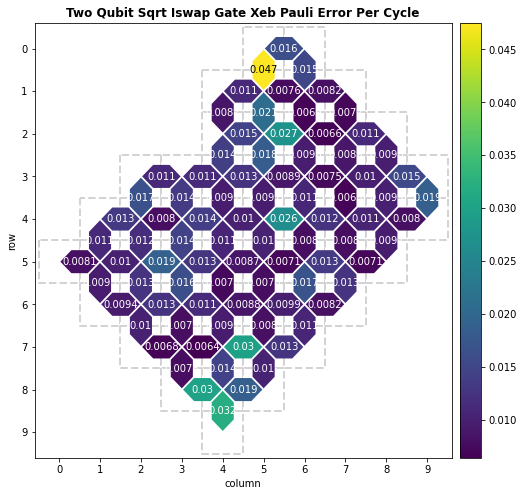

In [11]:
calibration = cg.get_engine_calibration(processor_id=processor_id)
metric = "two_qubit_sqrt_iswap_gate_xeb_pauli_error_per_cycle"

_ = calibration.heatmap(metric).plot()

Using this calibration information, we select several candidate sets of qubits to use.

Note: We intentionally select one qubit configuration with a high calibration error to show this propagates through in our results. In practice, one would usually want all qubit configurations to have low errors to find the best one.

In [12]:
"""Pick sets of qubits to run Loschmidt echoes on."""
qubit_sets_indices = [
    [(4, 7), (4, 8), (5, 8), (5, 7)],
    [(0, 5), (0, 6), (1, 6), (1, 5)],  # From the calibration, we expect this to be the worst configuration.
    [(2, 6), (2, 7), (3, 7), (3, 6)],
    [(7, 3), (7, 4), (8, 4), (8, 3)],
]

# Convert indices to grid qubits.
qubit_sets = [[cirq.GridQubit(*idx) for idx in qubit_indices] 
              for qubit_indices in qubit_sets_indices]

We now run the Loschmidt echo circuits on each candidate set of qubits.

In [13]:
"""Run the Loschmidt echo experiment."""
sampler = cg.get_engine_sampler(processor_id=processor_id, gate_set_name="sqrt_iswap")

probs = []
for trial in range(trials):
    print("\r", f"Status: On trial {trial + 1} / {trials}", end="")

    # Create the batch of circuits.
    batch = [
        create_loschmidt_echo_circuit(qubits, cycles=c, pause=pause, seed=trial)
        for qubits in qubit_sets for c in cycle_values
    ]

    # Run the batch.
    results = sampler.run_batch(programs=batch, repetitions=nreps)

    # Determine the ground state probability for each result.
    probs.append([to_ground_state_prob(*res) for res in results])

 Status: On trial 10 / 10

## Plotting the results

Below we plot the average survival probability on each qubit configuration.

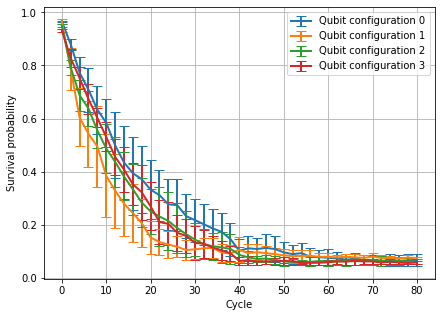

In [14]:
# Average data over trials.
avg_probs = np.average(probs, axis=0).reshape(len(qubit_sets), len(cycle_values))
std_probs = np.std(probs, axis=0).reshape(len(qubit_sets), len(cycle_values))

# Plotting.
plt.figure(figsize=(7, 5))

for i in range(len(qubit_sets)):
    plt.errorbar(
        x=cycle_values, 
        y=avg_probs[i], 
        yerr=std_probs[i],
        capsize=5,
        lw=2,
        label=f"Qubit configuration {i}"
    )

plt.legend()
plt.ylabel("Survival probability")
plt.xlabel("Cycle")
plt.grid("on");

The initial point (at zero cycles) reflects readout error, and the decay rate reflects the gate error per cycle. We fit an exponential to each curve to determine the gate error per cycle below.

Note: To ensure good fit parameters are calculated, it is important to collect enough data such that the above curves reach their asymptote.

In [15]:
"""Fit an exponential decay to the collected data."""
from scipy.optimize import curve_fit

def fit(cycle, a, f):
    return a * np.exp((f - 1.0) * cycle)


for i in range(len(qubit_sets)):
    (a, f), _ = curve_fit(
        fit,
        xdata=cycle_values, 
        ydata=avg_probs[i],
    )
    print(f"Error/cycle on qubit configuration {i}: {round((1 - f) * 100, 2)}%")

Error/cycle on qubit configuration 0: 4.85%
Error/cycle on qubit configuration 1: 7.35%
Error/cycle on qubit configuration 2: 5.87%
Error/cycle on qubit configuration 3: 6.0%


Note: The definition of cycle here is different than that used in the calibration metrics.

At this point we can select the qubit configuration with the lowest error per cycle (assuming all configurations are on the same number of qubits).